# random_forest_model
----

Written in the Python 3.7.9 Environment with the following package versions

    * joblib 1.0.1
    * numpy 1.19.5
    * pandas 1.3.1
    * scikit-learn 0.24.2
    * tensorflow 2.5.0

By Nicole Lund

This workbook builds a model from 2017 flight performance and predicts 2018 performance.

In [118]:
# Import Dependencies

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Data manipulation
import numpy as np
import pandas as pd
import math
import datetime
from statistics import mean
from operator import itemgetter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from tensorflow.keras.utils import to_categorical

# Parameter Selection
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Model Development
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Model Metrics
from sklearn.metrics import classification_report

# Save/load files
from tensorflow.keras.models import load_model
import joblib
# from google.colab import files

# # Ignore deprecation warnings
# import warnings
# warnings.simplefilter('ignore', FutureWarning)

In [119]:
# Set the seed value for the notebook, so the results are reproducible
from numpy.random import seed
seed(1)

# Read the clean CSV

In [120]:
# Import data
# Read the CSV file from Github to Pandas Dataframe
url = "https://raw.githubusercontent.com/NicoleLund/flight_delay_prediction/main/data_manipulation_modeling/data_clean/2017_TUS.csv"
df = pd.read_csv(url)

df.head(3)

,origin_city_name,dest_city_name,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,CRS_DEP_HM,DEP_TIME_HM,WHEELS_OFF_HM,WHEELS_ON_HM,CRS_ARR_TIME_HM,ARR_TIME_HM,day_of_week,DELAY
0,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2017-01-01,DL,2066,TUS,ATL,1430,1459.0,29.0,...,0.0,14.0,14:30,14:59,15:09,20:11,20:03,20:28,Sunday,0
1,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2017-01-02,DL,1127,TUS,ATL,600,637.0,37.0,...,0.0,0.0,06:00,06:37,06:47,11:57,11:29,12:03,Monday,1
2,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2017-01-02,DL,2066,TUS,ATL,1430,1447.0,17.0,...,NaN,NaN,14:30,14:47,14:57,19:43,20:05,19:52,Monday,0


# Additional Data Formatting

In [121]:
# Convert the time fields into decimal hour

def time_conv(mil_time):
  hours = []
  for time in mil_time:
    if time == 2400:
      time = 0
    if math.isnan(time):
      hours.append(time)
    elif time < 59:
      hour = int(datetime.datetime.strptime(str(int(time)), '%M').strftime('%H'))
      minute = int(datetime.datetime.strptime(str(int(time)), '%M').strftime('%M'))
      hours.append(hour + minute/60)  
    else:
      hour = int(datetime.datetime.strptime(str(int(time)), '%H%M').strftime('%H'))
      minute = int(datetime.datetime.strptime(str(int(time)), '%H%M').strftime('%M'))
      hours.append(hour + minute/60)  
  return hours

In [122]:
df['CRS_DEP_hours'] = time_conv(df['CRS_DEP_TIME'])
df['CRS_ARR_hours'] = time_conv(df['CRS_ARR_TIME'])

In [157]:
# Split dataframe into X and y
# Define model variables

# Model input
X_categorical_df = df[['OP_CARRIER', 'day_of_week', 'DEST']]
X_numeric_df = df[['OP_CARRIER_FL_NUM', 'CRS_DEP_hours', 'CRS_ARR_hours', 'DISTANCE']]
X_numeric_df.DISTANCE = X_numeric_df.DISTANCE.astype(int)

# Model output
y_df = df[['CANCELLED', 'DIVERTED', 'DELAY']]
y_df.CANCELLED = y_df.CANCELLED.astype(int)
y_df.DIVERTED = y_df.DIVERTED.astype(int)

In [124]:
# Review model output
print(y_df.info())
y_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15406 entries, 0 to 15405
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   CANCELLED  15406 non-null  int32
 1   DIVERTED   15406 non-null  int32
 2   DELAY      15406 non-null  int64
dtypes: int32(2), int64(1)
memory usage: 240.8 KB
None


,CANCELLED,DIVERTED,DELAY
0,0,0,0
1,0,0,1
2,0,0,0


In [125]:
# Review model numeric input
print(X_numeric_df.info())
X_numeric_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15406 entries, 0 to 15405
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   OP_CARRIER_FL_NUM  15406 non-null  int64  
 1   CRS_DEP_hours      15406 non-null  float64
 2   CRS_ARR_hours      15406 non-null  float64
 3   DISTANCE           15406 non-null  int32  
dtypes: float64(2), int32(1), int64(1)
memory usage: 421.4 KB
None


,OP_CARRIER_FL_NUM,CRS_DEP_hours,CRS_ARR_hours,DISTANCE
0,2066,14.5,20.050000,1541
1,1127,6.0,11.483333,1541
2,2066,14.5,20.083333,1541


In [126]:
# Review model categorical input
print(X_categorical_df.info())
X_categorical_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15406 entries, 0 to 15405
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   OP_CARRIER   15406 non-null  object
 1   day_of_week  15406 non-null  object
 2   DEST         15406 non-null  object
dtypes: object(3)
memory usage: 361.2+ KB
None


,OP_CARRIER,day_of_week,DEST
0,DL,Sunday,ATL
1,DL,Monday,ATL
2,DL,Monday,ATL


# One-hot encode categorical values

In [127]:
# View categories for one hot encoder
carriers = pd.unique(X_categorical_df.OP_CARRIER)
day = pd.unique(X_categorical_df.day_of_week)
destination = pd.unique(X_categorical_df.DEST)
print(carriers)
print(day)
print(destination)

['DL' 'OO' 'UA' 'WN' 'AA' 'EV' 'AS']
['Sunday' 'Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday']
['ATL' 'DEN' 'DFW' 'HOU' 'IAH' 'JFK' 'LAS' 'LAX' 'MDW' 'MSP' 'OAK' 'ORD'
 'PDX' 'PHX' 'SAN' 'SEA' 'SFO' 'SJC' 'SLC']


In [128]:
# Define categorical column names
column_names = ['DL', 'OO', 'UA', 'WN', 'AA', 'EV', 'AS', \
 'Sunday', 'Monday', 'Tuesday', 'Wednesday', \
 'Thursday', 'Friday', 'Saturday', 'ATL', 'DEN', \
 'DFW', 'HOU', 'IAH', 'JFK', 'LAS', 'LAX', 'MDW', \
 'MSP', 'OAK', 'ORD', 'PDX', 'PHX', 'SAN', 'SEA', 'SFO', 'SJC', 'SLC']

In [129]:
# One-hot-encode categorical fields
encoder = OneHotEncoder(categories=[carriers,day,destination])
encoder.fit(X_categorical_df)
X_encoded = encoder.transform(X_categorical_df)
X_encoded.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.]])

In [130]:
# Create encoded DataFrame of Categorical Fields
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=column_names).astype(int)
X_encoded_df.tail(5)

,DL,OO,UA,WN,AA,EV,AS,Sunday,Monday,Tuesday,...,MSP,OAK,ORD,PDX,PHX,SAN,SEA,SFO,SJC,SLC
15401,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
15402,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
15403,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
15404,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
15405,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [131]:
# Join encoded data to original DataFrame
encoded_df = df
encoded_df = encoded_df.join(X_encoded_df)
encoded_df.head(3)

,origin_city_name,dest_city_name,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,MSP,OAK,ORD,PDX,PHX,SAN,SEA,SFO,SJC,SLC
0,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2017-01-01,DL,2066,TUS,ATL,1430,1459.0,29.0,...,0,0,0,0,0,0,0,0,0,0
1,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2017-01-02,DL,1127,TUS,ATL,600,637.0,37.0,...,0,0,0,0,0,0,0,0,0,0
2,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2017-01-02,DL,2066,TUS,ATL,1430,1447.0,17.0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
# Join encoded data to X
X_df = X_numeric_df
X_df = X_df.join(X_encoded_df)
X_df.head(3)

,OP_CARRIER_FL_NUM,CRS_DEP_hours,CRS_ARR_hours,DISTANCE,DL,OO,UA,WN,AA,EV,...,MSP,OAK,ORD,PDX,PHX,SAN,SEA,SFO,SJC,SLC
0,2066,14.5,20.050000,1541,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1127,6.0,11.483333,1541,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2066,14.5,20.083333,1541,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [135]:
# Verify resulting dataframe shapes
print(X_numeric_df.shape)
print(X_encoded_df.shape)
print(X_df.shape)

(15406, 4)
(15406, 33)
(15406, 37)


In [136]:
# Show any NaNs
X_df[X_df.isna().any(axis=1)]

,OP_CARRIER_FL_NUM,CRS_DEP_hours,CRS_ARR_hours,DISTANCE,DL,OO,UA,WN,AA,EV,...,MSP,OAK,ORD,PDX,PHX,SAN,SEA,SFO,SJC,SLC


# Model Pre-Processing

In [137]:
# Split X and y into training and testing groups
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_df, test_size=0.3, random_state=42)

In [138]:
# Display training data
X_train.head(3)

,OP_CARRIER_FL_NUM,CRS_DEP_hours,CRS_ARR_hours,DISTANCE,DL,OO,UA,WN,AA,EV,...,MSP,OAK,ORD,PDX,PHX,SAN,SEA,SFO,SJC,SLC
10939,5538,11.333333,16.783333,1437,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
10779,5538,12.316667,16.833333,1437,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
10092,2068,16.416667,20.666667,1440,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [139]:
# Scale the data with MinMaxScaler
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Random Forest Modeling

In [19]:
# Hyperparamter tuning
model = RandomForestClassifier(n_jobs=-1) 

param_grid = { 
    'n_estimators': [100, 1000, 5000],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy')
grid.fit(X_train, y_train)
grid.best_params_

{'max_features': 'auto', 'n_estimators': 5000}

In [21]:
# Save the grid
joblib.dump(grid, './random_forest_grid_v2.sav')

['./random_forest_grid_v2.sav']

In [22]:
# Build final model
best_model = RandomForestClassifier(n_estimators=5000, max_features= 'auto', n_jobs=-1) 
best_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5000, n_jobs=-1)

In [23]:
# Save the model
joblib.dump(best_model, './random_forest_model_v2.sav')

['./random_forest_model_v2.sav']

# Score the model

In [140]:
print(f'Random Forest Score: {best_model.score(X_test, y_test)}')

Random Forest Score: 0.869104283859801


In [141]:
predictions = best_model.predict(X_test)
results_cancelled = pd.DataFrame({ \
            "CANCELLED": y_test.CANCELLED,"CANCELLED_PREDICT": predictions[:,0]})
results_diverted = pd.DataFrame({ \
            "DIVERTED": y_test.DIVERTED,"DIVERTED_PREDICT": predictions[:,1]})
results_delayed = pd.DataFrame({ \
            "DELAY": y_test.DELAY, "DELAY_PREDICT": predictions[:,2]})

In [142]:
print(classification_report(y_test.CANCELLED, predictions[:,0]))
results_cancelled.apply(pd.value_counts)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4590
           1       0.00      0.00      0.00        32

    accuracy                           0.99      4622
   macro avg       0.50      0.50      0.50      4622
weighted avg       0.99      0.99      0.99      4622



C:\Users\nlund\anaconda3\envs\PythonDataV2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nlund\anaconda3\envs\PythonDataV2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nlund\anaconda3\envs\PythonDataV2\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,CANCELLED,CANCELLED_PREDICT
0,4590,4622.0
1,32,NaN


In [143]:
print(classification_report(y_test.DIVERTED, predictions[:,1]))
results_diverted.apply(pd.value_counts)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4613
           1       0.00      0.00      0.00         9

    accuracy                           1.00      4622
   macro avg       0.50      0.50      0.50      4622
weighted avg       1.00      1.00      1.00      4622



,DIVERTED,DIVERTED_PREDICT
0,4613,4621
1,9,1


In [144]:
print(classification_report(y_test.DELAY, predictions[:,2]))
results_delayed.apply(pd.value_counts)

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      4087
           1       0.31      0.10      0.16       535

    accuracy                           0.87      4622
   macro avg       0.60      0.54      0.54      4622
weighted avg       0.82      0.87      0.84      4622



,DELAY,DELAY_PREDICT
0,4087,4442
1,535,180


# Review Feature Importance

In [145]:
# Sort the features by their importance
rf_feature_sort = sorted(zip(X_train.columns,best_model.feature_importances_),key=itemgetter(1), reverse=False)
# rf_feature_sort

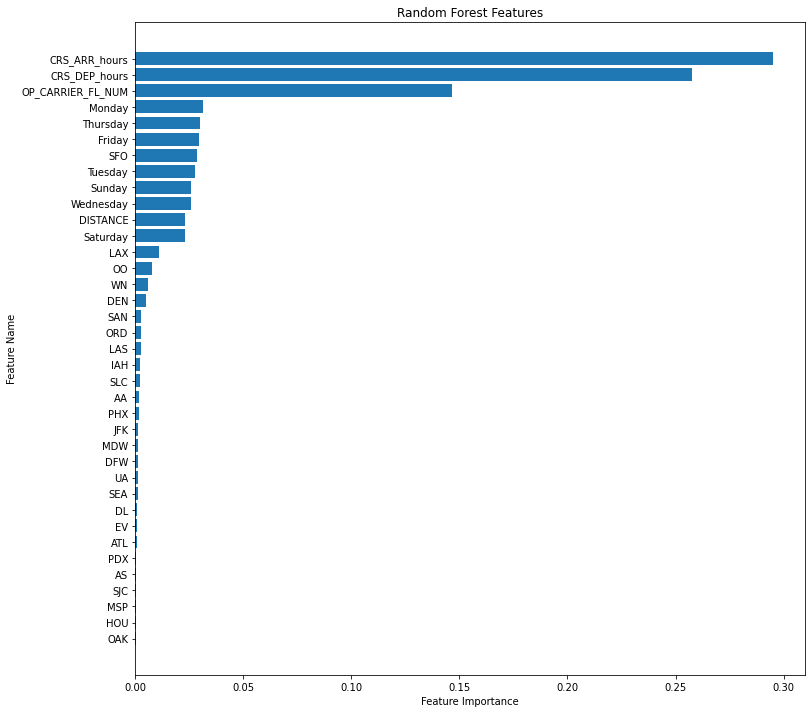

In [146]:
# Plot Random Forest Feature Importance
fig = plt.figure(figsize=[12,12])
plt.barh(*zip(* (rf_feature_sort)))
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Random Forest Features')
plt.show()

# Format 2018 data for prediction

In [147]:
# Import data
# Read the CSV file from Github to Pandas Dataframe
df_2018 = pd.read_csv('https://raw.githubusercontent.com/NicoleLund/flight_delay_prediction/main/data_manipulation_modeling/data_clean/2018_TUS.csv')
df_2018.head(3)

,origin_city_name,dest_city_name,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,CRS_DEP_HM,DEP_TIME_HM,WHEELS_OFF_HM,WHEELS_ON_HM,CRS_ARR_TIME_HM,ARR_TIME_HM,day_of_week,DELAY
0,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2018-01-01,DL,1240,TUS,ATL,1453,1600.0,67.0,...,0.0,55.0,14:53,16:00,16:27,21:18,20:29,21:24,Monday,1
1,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2018-01-01,DL,1345,TUS,ATL,710,705.0,-5.0,...,NaN,NaN,07:10,07:05,07:15,12:10,12:39,12:14,Monday,0
2,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2018-01-02,DL,1240,TUS,ATL,1453,1446.0,-7.0,...,NaN,NaN,14:53,14:46,15:03,19:54,20:29,20:04,Tuesday,0


In [148]:
# Convert the time fields into decimal hour for 2018 Prediction
df_2018['CRS_DEP_hours'] = time_conv(df_2018['CRS_DEP_TIME'])
df_2018['CRS_ARR_hours'] = time_conv(df_2018['CRS_ARR_TIME'])

In [149]:
# Review Categorical Values vs model categories
X_categorical_2018_df = df_2018[['OP_CARRIER', 'day_of_week', 'DEST']]

# View categories for one hot encoder
carriers_2018 = pd.unique(X_categorical_2018_df.OP_CARRIER)
day_2018 = pd.unique(X_categorical_2018_df.day_of_week)
destination_2018 = pd.unique(X_categorical_2018_df.DEST)
print(carriers_2018)
print(day_2018)
print(destination_2018)
print('------Expected Categories---------')
print(column_names)

['DL' 'G4' 'AA' 'UA' 'OO' 'WN' 'F9' 'EV' 'YV' 'AS']
['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']
['ATL' 'BLI' 'CLT' 'DEN' 'DFW' 'HOU' 'IAH' 'LAS' 'LAX' 'MDW' 'MSP' 'OAK'
 'ORD' 'PDX' 'PHX' 'PVU' 'SAN' 'SEA' 'SFO' 'SJC' 'SLC']
------Expected Categories---------
['DL', 'OO', 'UA', 'WN', 'AA', 'EV', 'AS', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'ATL', 'DEN', 'DFW', 'HOU', 'IAH', 'JFK', 'LAS', 'LAX', 'MDW', 'MSP', 'OAK', 'ORD', 'PDX', 'PHX', 'SAN', 'SEA', 'SFO', 'SJC', 'SLC']


In [150]:
# Sequester the data between predictable and not predictable sets
# i.e. sequestering data with new categories
df_2018_newCarriers = df_2018
df_2018_newDestinations = df_2018
df_2018_predict = df_2018

for carrier in carriers_2018:
    if carrier in column_names:
        df_2018_newCarriers = df_2018_newCarriers.loc[df_2018_newCarriers['OP_CARRIER'] != carrier]
    else:
        print(carrier + ' not found')
        df_2018_predict = df_2018_predict.loc[df_2018_predict['OP_CARRIER'] != carrier]

for destination in destination_2018:
    if destination in column_names:
        df_2018_newDestinations = df_2018_newDestinations.loc[df_2018_newDestinations['DEST'] != destination]
    else:
        print(destination + ' not found')
        df_2018_predict = df_2018_predict.loc[df_2018_predict['DEST'] != destination]

G4 not found
F9 not found
YV not found
BLI not found
CLT not found
PVU not found


In [151]:
# Verify results of data sequestration
print(pd.unique(df_2018_predict.OP_CARRIER))
print(pd.unique(df_2018_predict.DEST))

['DL' 'UA' 'OO' 'WN' 'AA' 'EV' 'AS']
['ATL' 'DEN' 'DFW' 'HOU' 'IAH' 'LAS' 'LAX' 'MDW' 'MSP' 'OAK' 'ORD' 'PDX'
 'PHX' 'SAN' 'SEA' 'SFO' 'SJC' 'SLC']


In [152]:
# Verify results of data sequestration
print(pd.unique(df_2018_newCarriers.OP_CARRIER))
print(pd.unique(df_2018_newCarriers.DEST))

['G4' 'F9' 'YV']
['BLI' 'DEN' 'IAH' 'PHX' 'PVU']


In [153]:
# Verify results of data sequestration
print(pd.unique(df_2018_newDestinations.OP_CARRIER))
print(pd.unique(df_2018_newDestinations.DEST))

['G4' 'AA']
['BLI' 'CLT' 'PVU']


In [154]:
# Combine the not predicted data sets
df_2018_not_predict = df_2018_newCarriers.append(df_2018_newDestinations)

# Drop duplicate rows
df_2018_not_predict.drop_duplicates(inplace=True)

print(pd.unique(df_2018_not_predict.OP_CARRIER))
print(pd.unique(df_2018_not_predict.DEST))

['G4' 'F9' 'YV' 'AA']
['BLI' 'DEN' 'IAH' 'PHX' 'PVU' 'CLT']


In [155]:
# Verify all data is accounted for
print(df_2018.shape)
print(df_2018_predict.shape)
print(df_2018_not_predict.shape)
print(df_2018_predict.shape[0] + df_2018_not_predict.shape[0])

(18223, 39)
(15400, 39)
(2823, 39)
18223


In [158]:
# Define Model input for 2018 Prediction
X_categorical_2018_df = df_2018_predict[['OP_CARRIER', 'day_of_week', 'DEST']]
X_numeric_2018_df = df_2018_predict[['OP_CARRIER_FL_NUM', 'CRS_DEP_hours', 'CRS_ARR_hours', 'DISTANCE']]
X_numeric_2018_df.DISTANCE = X_numeric_2018_df.DISTANCE.astype(int)

In [159]:
# View categories for one hot encoder
print(pd.unique(X_categorical_2018_df.OP_CARRIER))
print(pd.unique(X_categorical_df.day_of_week))
print(pd.unique(X_categorical_df.DEST))

['DL' 'UA' 'OO' 'WN' 'AA' 'EV' 'AS']
['Sunday' 'Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday']
['ATL' 'DEN' 'DFW' 'HOU' 'IAH' 'JFK' 'LAS' 'LAX' 'MDW' 'MSP' 'OAK' 'ORD'
 'PDX' 'PHX' 'SAN' 'SEA' 'SFO' 'SJC' 'SLC']


In [160]:
# One-hot-encode categorical fields for 2018 Prediction
X_encoded_2018 = encoder.transform(X_categorical_2018_df)
X_encoded_2018.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.]])

In [173]:
# Create encoded DataFrame of Categorical Fields for 2018 Prediction
X_encoded_2018_df = pd.DataFrame(X_encoded_2018.toarray(), columns=column_names, index=X_categorical_2018_df.index).astype(int)
X_encoded_2018_df.tail(3)

,DL,OO,UA,WN,AA,EV,AS,Sunday,Monday,Tuesday,...,MSP,OAK,ORD,PDX,PHX,SAN,SEA,SFO,SJC,SLC
18220,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
18221,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
18222,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [174]:
print(X_numeric_2018_df.shape)
print(X_encoded_2018_df.shape)

(15400, 4)
(15400, 33)


In [175]:
X_numeric_2018_df[X_numeric_2018_df.isna().any(axis=1)]

,OP_CARRIER_FL_NUM,CRS_DEP_hours,CRS_ARR_hours,DISTANCE


In [176]:
X_encoded_2018_df[X_encoded_2018_df.isna().any(axis=1)]

,DL,OO,UA,WN,AA,EV,AS,Sunday,Monday,Tuesday,...,MSP,OAK,ORD,PDX,PHX,SAN,SEA,SFO,SJC,SLC


In [177]:
X_numeric_2018_df

,OP_CARRIER_FL_NUM,CRS_DEP_hours,CRS_ARR_hours,DISTANCE
0,1240,14.883333,20.483333,1541
1,1345,7.166667,12.650000,1541
2,1240,14.883333,20.483333,1541
3,1345,7.166667,12.650000,1541
4,1240,13.666667,19.216667,1541
...,...,...,...,...
18218,3942,17.483333,19.566667,601
18219,4539,8.083333,10.200000,601
18220,4567,12.283333,14.333333,601
18221,4539,8.166667,10.250000,601


In [178]:
X_encoded_2018_df

,DL,OO,UA,WN,AA,EV,AS,Sunday,Monday,Tuesday,...,MSP,OAK,ORD,PDX,PHX,SAN,SEA,SFO,SJC,SLC
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18218,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
18219,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
18220,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
18221,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [180]:
# Join encoded data to X
X_2018_df = X_numeric_2018_df
X_2018_df = X_2018_df.join(X_encoded_2018_df)
X_2018_df.head(3)

,OP_CARRIER_FL_NUM,CRS_DEP_hours,CRS_ARR_hours,DISTANCE,DL,OO,UA,WN,AA,EV,...,MSP,OAK,ORD,PDX,PHX,SAN,SEA,SFO,SJC,SLC
0,1240,14.883333,20.483333,1541,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1345,7.166667,12.650000,1541,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1240,14.883333,20.483333,1541,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [181]:
X_2018_df[X_2018_df.isna().any(axis=1)]

,OP_CARRIER_FL_NUM,CRS_DEP_hours,CRS_ARR_hours,DISTANCE,DL,OO,UA,WN,AA,EV,...,MSP,OAK,ORD,PDX,PHX,SAN,SEA,SFO,SJC,SLC


In [182]:
# Scale the prediction data
X_2018_scaled_df = X_scaler.transform(X_2018_df)

# Make 2018 predictions

In [183]:
predictions_2018 = best_model.predict(X_2018_scaled_df)

In [185]:
# Verify array shapes
print(predictions_2018.shape)
print(df_2018_predict.shape)

(15400, 3)
(15400, 39)


In [186]:
# Create DataFrame of predictions
predictions_2018_df = pd.DataFrame({ \
            "CANCELLED_PREDICT": predictions_2018[:,0], \
            "DIVERTED_PREDICT": predictions_2018[:,1], \
            "DELAY_PREDICT": predictions_2018[:,2]})
predictions_2018_df.head()

,CANCELLED_PREDICT,DIVERTED_PREDICT,DELAY_PREDICT
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [188]:
# Join predicted data to full file
df_2018_predictions = df_2018_predict
df_2018_predictions = df_2018_predictions.join(predictions_2018_df)
df_2018_predictions.head(3)

,origin_city_name,dest_city_name,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,WHEELS_ON_HM,CRS_ARR_TIME_HM,ARR_TIME_HM,day_of_week,DELAY,CRS_DEP_hours,CRS_ARR_hours,CANCELLED_PREDICT,DIVERTED_PREDICT,DELAY_PREDICT
0,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2018-01-01,DL,1240,TUS,ATL,1453,1600.0,67.0,...,21:18,20:29,21:24,Monday,1,14.883333,20.483333,0.0,0.0,0.0
1,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2018-01-01,DL,1345,TUS,ATL,710,705.0,-5.0,...,12:10,12:39,12:14,Monday,0,7.166667,12.650000,0.0,0.0,0.0
2,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2018-01-02,DL,1240,TUS,ATL,1453,1446.0,-7.0,...,19:54,20:29,20:04,Tuesday,0,14.883333,20.483333,0.0,0.0,0.0


In [189]:
print(df_2018_predictions.shape)

(15400, 42)


In [190]:
df_2018_predictions

,origin_city_name,dest_city_name,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,WHEELS_ON_HM,CRS_ARR_TIME_HM,ARR_TIME_HM,day_of_week,DELAY,CRS_DEP_hours,CRS_ARR_hours,CANCELLED_PREDICT,DIVERTED_PREDICT,DELAY_PREDICT
0,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2018-01-01,DL,1240,TUS,ATL,1453,1600.0,67.0,...,21:18,20:29,21:24,Monday,1,14.883333,20.483333,0.0,0.0,0.0
1,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2018-01-01,DL,1345,TUS,ATL,710,705.0,-5.0,...,12:10,12:39,12:14,Monday,0,7.166667,12.650000,0.0,0.0,0.0
2,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2018-01-02,DL,1240,TUS,ATL,1453,1446.0,-7.0,...,19:54,20:29,20:04,Tuesday,0,14.883333,20.483333,0.0,0.0,0.0
3,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2018-01-02,DL,1345,TUS,ATL,710,703.0,-7.0,...,12:04,12:39,12:09,Tuesday,0,7.166667,12.650000,0.0,0.0,0.0
4,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2018-01-03,DL,1240,TUS,ATL,1340,1335.0,-5.0,...,18:42,19:13,18:52,Wednesday,0,13.666667,19.216667,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18218,"TUCSON, ARIZONA, USA","SALT LAKE CITY, UTAH, USA",2018-12-30,OO,3942,TUS,SLC,1729,1735.0,6.0,...,19:25,19:34,19:30,Sunday,0,17.483333,19.566667,NaN,NaN,NaN
18219,"TUCSON, ARIZONA, USA","SALT LAKE CITY, UTAH, USA",2018-12-30,OO,4539,TUS,SLC,805,753.0,-12.0,...,09:57,10:12,10:10,Sunday,0,8.083333,10.200000,NaN,NaN,NaN
18220,"TUCSON, ARIZONA, USA","SALT LAKE CITY, UTAH, USA",2018-12-30,OO,4567,TUS,SLC,1217,1211.0,-6.0,...,13:59,14:20,14:03,Sunday,0,12.283333,14.333333,NaN,NaN,NaN
18221,"TUCSON, ARIZONA, USA","SALT LAKE CITY, UTAH, USA",2018-12-31,OO,4539,TUS,SLC,810,801.0,-9.0,...,09:46,10:15,09:53,Monday,0,8.166667,10.250000,NaN,NaN,NaN


In [200]:
# Add not predicted items into the full dataset
df_2018_results = df_2018_predictions.append(df_2018_not_predict)
df_2018_results

,origin_city_name,dest_city_name,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,WHEELS_ON_HM,CRS_ARR_TIME_HM,ARR_TIME_HM,day_of_week,DELAY,CRS_DEP_hours,CRS_ARR_hours,CANCELLED_PREDICT,DIVERTED_PREDICT,DELAY_PREDICT
0,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2018-01-01,DL,1240,TUS,ATL,1453,1600.0,67.0,...,21:18,20:29,21:24,Monday,1,14.883333,20.483333,0.0,0.0,0.0
1,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2018-01-01,DL,1345,TUS,ATL,710,705.0,-5.0,...,12:10,12:39,12:14,Monday,0,7.166667,12.650000,0.0,0.0,0.0
2,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2018-01-02,DL,1240,TUS,ATL,1453,1446.0,-7.0,...,19:54,20:29,20:04,Tuesday,0,14.883333,20.483333,0.0,0.0,0.0
3,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2018-01-02,DL,1345,TUS,ATL,710,703.0,-7.0,...,12:04,12:39,12:09,Tuesday,0,7.166667,12.650000,0.0,0.0,0.0
4,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2018-01-03,DL,1240,TUS,ATL,1340,1335.0,-5.0,...,18:42,19:13,18:52,Wednesday,0,13.666667,19.216667,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,"TUCSON, ARIZONA, USA","CHARLOTTE, NORTH CAROLINA, USA",2018-12-27,AA,1850,TUS,CLT,46,1233.0,707.0,...,18:25,06:30,18:33,Thursday,1,0.766667,6.500000,NaN,NaN,NaN
971,"TUCSON, ARIZONA, USA","CHARLOTTE, NORTH CAROLINA, USA",2018-12-28,AA,1850,TUS,CLT,46,118.0,32.0,...,06:42,06:30,06:52,Friday,0,0.766667,6.500000,NaN,NaN,NaN
972,"TUCSON, ARIZONA, USA","CHARLOTTE, NORTH CAROLINA, USA",2018-12-29,AA,1850,TUS,CLT,46,151.0,65.0,...,07:05,06:30,07:10,Saturday,1,0.766667,6.500000,NaN,NaN,NaN
973,"TUCSON, ARIZONA, USA","CHARLOTTE, NORTH CAROLINA, USA",2018-12-30,AA,1850,TUS,CLT,46,48.0,2.0,...,06:11,06:30,06:16,Sunday,0,0.766667,6.500000,NaN,NaN,NaN


In [201]:
print(df_2018.shape)
print(df_2018_results.shape)

(18223, 39)
(18223, 42)


In [202]:
df_2018_results = df_2018_results.sort_index()

In [203]:
df_2018_results

,origin_city_name,dest_city_name,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,WHEELS_ON_HM,CRS_ARR_TIME_HM,ARR_TIME_HM,day_of_week,DELAY,CRS_DEP_hours,CRS_ARR_hours,CANCELLED_PREDICT,DIVERTED_PREDICT,DELAY_PREDICT
0,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2018-01-01,DL,1240,TUS,ATL,1453,1600.0,67.0,...,21:18,20:29,21:24,Monday,1,14.883333,20.483333,0.0,0.0,0.0
1,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2018-01-01,DL,1345,TUS,ATL,710,705.0,-5.0,...,12:10,12:39,12:14,Monday,0,7.166667,12.650000,0.0,0.0,0.0
2,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2018-01-02,DL,1240,TUS,ATL,1453,1446.0,-7.0,...,19:54,20:29,20:04,Tuesday,0,14.883333,20.483333,0.0,0.0,0.0
3,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2018-01-02,DL,1345,TUS,ATL,710,703.0,-7.0,...,12:04,12:39,12:09,Tuesday,0,7.166667,12.650000,0.0,0.0,0.0
4,"TUCSON, ARIZONA, USA","ATLANTA, GEORGIA, USA",2018-01-03,DL,1240,TUS,ATL,1340,1335.0,-5.0,...,18:42,19:13,18:52,Wednesday,0,13.666667,19.216667,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18218,"TUCSON, ARIZONA, USA","SALT LAKE CITY, UTAH, USA",2018-12-30,OO,3942,TUS,SLC,1729,1735.0,6.0,...,19:25,19:34,19:30,Sunday,0,17.483333,19.566667,NaN,NaN,NaN
18219,"TUCSON, ARIZONA, USA","SALT LAKE CITY, UTAH, USA",2018-12-30,OO,4539,TUS,SLC,805,753.0,-12.0,...,09:57,10:12,10:10,Sunday,0,8.083333,10.200000,NaN,NaN,NaN
18220,"TUCSON, ARIZONA, USA","SALT LAKE CITY, UTAH, USA",2018-12-30,OO,4567,TUS,SLC,1217,1211.0,-6.0,...,13:59,14:20,14:03,Sunday,0,12.283333,14.333333,NaN,NaN,NaN
18221,"TUCSON, ARIZONA, USA","SALT LAKE CITY, UTAH, USA",2018-12-31,OO,4539,TUS,SLC,810,801.0,-9.0,...,09:46,10:15,09:53,Monday,0,8.166667,10.250000,NaN,NaN,NaN


In [204]:
# Save output to csv
df_2018_results.to_csv('2018_TUS_wPredictions_v2.csv', index = False)